## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, OrdinalEncoder, RobustScaler,\
                                    OneHotEncoder,MaxAbsScaler, PolynomialFeatures, LabelEncoder, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import Pool, CatBoostClassifier
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgbm
from sklearn.pipeline import make_pipeline

RANDOM_STATE = 0

%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_sample_solution = pd.read_csv("sample_solution.csv")

df_named = pd.read_csv("named.csv")
df_type_contract = pd.read_csv("type_contract.csv")
df_log = pd.read_csv("log.csv")

## Рассмотрим датасет по ближе

In [4]:
df_train.head(3)

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0


In [8]:
df_named.head(3)

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335


In [9]:
df_type_contract.head(3)

,contract_id,day_or_month_contract
0,7780,0
1,7784,0
2,7785,0


In [10]:
df_log.head(3)

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета


Узнаем размерность наборов

In [3]:
print("df_train", df_train.shape)
print("df_named", df_named.shape)
print("df_sample_solution", df_sample_solution.shape)
print("df_type_contract", df_type_contract.shape)
print("df_log", df_log.shape)

df_train (5992, 2)
df_named (10646537, 3)
df_sample_solution (810, 2)
df_type_contract (6805, 2)
df_log (25274, 3)


### Видоизмение данных

Обьединим два набора с данными

In [4]:
df_test = df_sample_solution.copy()
df_all = pd.concat([df_train, df_test])

Подсчитаем количество обращений и url

In [5]:
%%time
count_log = df_log.groupby("contract_id").count().rename(columns={'event_date': 'count_event'})
count_named = df_named.groupby("contract_id")[['url']].count().rename(columns={'url': 'count_url'})

Wall time: 8 s


Смержим подсчитанные данные

In [6]:
df_all = pd.merge(df_all, df_type_contract, on="contract_id", how='left').drop_duplicates(subset="contract_id")
df_all = pd.merge(df_all, count_log, on="contract_id", how='left').drop(["event_type"],axis=1)
df_all = pd.merge(df_all, count_named, on="contract_id", how='left')

Логарифмирование count_event

In [7]:
df_all['count_event'] = np.log(df_all['count_event'], where=(df_all['count_event']!=0)).fillna(0)

one-hot кодирование событий

In [8]:
df_log_ = pd.get_dummies(df_log, columns=['event_type'])
df_log_ = df_log_.groupby('contract_id', as_index=False).sum()
df_all = pd.merge(df_all, df_log_, on="contract_id", how='left').drop_duplicates(subset="contract_id")

In [9]:
df_all.columns

Index(['contract_id', 'blocked', 'day_or_month_contract', 'count_event',
       'count_url', 'event_type_Абонент оставил отзыв в Личном кабинете',
       'event_type_Активация ГП с IVR',
       'event_type_Активация автоматического гарантированного платежа',
       'event_type_Активация гарантированного платежа',
       'event_type_Активация точки подключения на сутки',
       ...
       'event_type_Турбокнопка платно (1 сутки)',
       'event_type_Турбокнопка платно (1 час)',
       'event_type_Уведомления: отключение',
       'event_type_Уведомления: подключение',
       'event_type_Уведомления: подтверждение',
       'event_type_Удаление ip-адреса',
       'event_type_Удаление из Обращались с номеров',
       'event_type_Удаление телефона из записи',
       'event_type_Футболка Ситилинк',
       'event_type_Чек лист выполненных работ при регистрации'],
      dtype='object', length=110)

In [10]:
df_all_ = df_all.copy()

Оставляем последний url запроса к доменам конкурентов по каждому контракту и мержим  с основным фреймом

In [11]:
df_named_ = df_named.sort_values('date').drop_duplicates('contract_id', keep='last')

In [12]:
df_all_ = pd.merge(df_all_, df_named_[['contract_id', 'url']], on="contract_id", how='left')

one-hot кодинг url

In [13]:
df_all_ = pd.get_dummies(df_all_, columns=['url'])

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  5992 non-null   int64
 1   blocked      5992 non-null   int64
dtypes: int64(2)
memory usage: 93.8 KB


Заменим пропуски на нули

In [15]:
df_all_.fillna(0, inplace=True)

## Выделим выборки

In [16]:
df_train = df_all_[:df_train.shape[0]]
df_test = df_all_[df_train.shape[0]:]

In [17]:
X = df_train.drop(['contract_id', "blocked"], axis = 1)
y = df_train[["blocked"]]
test = df_test.drop(['contract_id', "blocked"], axis = 1)

In [18]:
X.columns

Index(['day_or_month_contract', 'count_event', 'count_url',
       'event_type_Абонент оставил отзыв в Личном кабинете',
       'event_type_Активация ГП с IVR',
       'event_type_Активация автоматического гарантированного платежа',
       'event_type_Активация гарантированного платежа',
       'event_type_Активация точки подключения на сутки',
       'event_type_Без границ бесплатно. Включение',
       'event_type_Без границ бесплатно. Отключение',
       ...
       'url_wifi.sampo.ru', 'url_wifilogin.sampo.ru',
       'url_wiki.extreme.sampo.ru', 'url_wink.rt.ru', 'url_wpad.sampo.ru',
       'url_www.company.rt.ru', 'url_www.karelia.rt.ru',
       'url_www.kclinic.sampo.ru', 'url_www.rt.ru', 'url_www.sampo.ru'],
      dtype='object', length=306)

## Обучение модели и оценка точности

Функции для обучения

In [19]:
# Функция для визуализации "матрицы неопределенности"
def view_test(true_labels, pred_labels, labels_train):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for i in range(2):
        cm = confusion_matrix(true_labels, pred_labels, labels=labels_train, normalize=['true', None][i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_train)
        disp.plot(ax=axes[i]);

# Удаление выбросов
def drop_outers(X, y):
    print('X shape', X.shape)
    ocs = OneClassSVM(nu=0.01)
    yhat = ocs.fit_predict(X)
    mask = yhat != -1
    X_svm, y_svm = X.loc[mask, :], y[mask]
    print('X shape without outers ', X_svm.shape)
    return X_svm, y_svm

# Обучение моделей
# Параметры zero_scale - во сколько раз должно быть превышение нулевого класса, n_folds - кол-во фолдов для обучения
def get_users(X, test, y, y_test=[], zero_scale=1.5, n_folds=5, is_test=True):
    
    X_svm, y_svm = drop_outers(X, y)
    
    clf_rfc = RandomForestClassifier(
        n_estimators=700,
        min_samples_split=7,
        max_depth=20,
        random_state=RANDOM_STATE)
    
#     Переменная - порог округления 
    predict_round_rate = 0.45
#     Вид метрики recall
    average_recall = 'weighted'
    
#     кастомный recall для xboost
    def custom_recall(y_true, y_pred):
        return -recall_score(y_true.astype(int), 
                             [1 if x>=predict_round_rate else 0 for x in y_pred], average=average_recall, zero_division=0)

    clf_xgb = xgb.XGBClassifier(
                         max_depth = 5,
                         n_estimators = 100,
                         learning_rate = 0.1,
                         subsample = 0.8,
                         colsample_bytree = 0.8,
                         eval_metric = custom_recall,
                         random_state=RANDOM_STATE)
    
        
    
    clf_cat = CatBoostClassifier(
                            eval_metric='Recall',                            
                            random_state=RANDOM_STATE)

    clf_ = make_pipeline(
                        QuantileTransformer(), 
                        LogisticRegression())

    
    
    size_not_blocked = y[y['blocked']==0].shape[0]
    size_blocked = y[y['blocked']==1].shape[0]

    scores_f1 = []
    scores_recall = []
    scores_recall_rfc = []
    scores_recall_xgb = []
    scores_recall_lrc = []
    scores_recall_cat = []
    
    scores_precision = []
    preds_probs = []
    preds_probs_rfc = []
    preds_probs_xgb = []
    preds_probs_lrc = []    
    preds_probs_cat = []
    
    X_not_blocked = X_svm[y_svm['blocked']==0].reset_index(drop=True)
    y_not_blocked = y_svm[y_svm['blocked']==0].reset_index(drop=True)
    X_blocked = X[y['blocked']==1]
    y_blocked = y[y['blocked']==1]
    blocked_size = y_blocked.shape[0]
    
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    cnt = 0
        
    for train_ix, test_ix in tqdm(list(kfold.split(X_not_blocked, y_not_blocked))):
            
        if len(test_ix) < int(blocked_size * zero_scale):
            test_ix = np.concatenate([test_ix, 
                                      y_not_blocked.loc[train_ix, :].sample(int(blocked_size * zero_scale)-len(test_ix), 
                                                           random_state=RANDOM_STATE).index])
        else:
            test_ix = y_not_blocked.loc[train_ix, :].sample(int(blocked_size * zero_scale), 
                                                            random_state=RANDOM_STATE).index 
        
        X_ = pd.concat([X_not_blocked.loc[test_ix, :], X_blocked])
        y_ = pd.concat([y_not_blocked.loc[test_ix, :], y_blocked])
        count_y = y_['blocked'].value_counts().to_dict()
        
        print(f'>Fold {cnt+1} of {n_folds}: {count_y}, scale:', np.round(count_y[0] / count_y[1], 3))

        clf_rfc.fit(X_, y_)
        if is_test:
            clf_xgb.fit(X_, y_, eval_set=[(test, y_test)])
        else:
            clf_xgb.fit(X_, y_)
        clf_.fit(X_, y_)
        
        clf_cat.fit(X_, y_, verbose=10)
        
        pred_proba_rfc = clf_rfc.predict_proba(test)[:,1]        
        pred_proba_xgb = clf_xgb.predict_proba(test)[:,1]
        pred_proba_lrc = clf_.predict_proba(test)[:,1]
        
        pred_proba_cat = clf_cat.predict_proba(test)[:,1]

        pred_ = (pred_proba_rfc + pred_proba_xgb + pred_proba_lrc + pred_proba_cat)/4        
        
        pred_ = [1 if x>=predict_round_rate else 0 for x in pred_]
        
        if is_test:
            pred_rfc_ = [1 if x>=predict_round_rate else 0 for x in pred_proba_rfc]
            pred_xgb_ = [1 if x>=predict_round_rate else 0 for x in pred_proba_xgb]
            pred_lrc_ = [1 if x>=predict_round_rate else 0 for x in pred_proba_lrc]             
            pred_cat_ = [1 if x>=predict_round_rate else 0 for x in pred_proba_cat]

            scores_recall.append(np.round(recall_score(y_test, pred_, average=average_recall, zero_division=0), 3))
            scores_recall_rfc.append(np.round(recall_score(y_test, pred_rfc_, average=average_recall, zero_division=0), 3))
            scores_recall_xgb.append(np.round(recall_score(y_test, pred_xgb_, average=average_recall, zero_division=0), 3))
            scores_recall_lrc.append(np.round(recall_score(y_test, pred_lrc_, average=average_recall, zero_division=0), 3))            
            scores_recall_cat.append(np.round(recall_score(y_test, pred_cat_, average=average_recall, zero_division=0), 3))
            
            preds_probs_rfc.append(pred_rfc_)
            preds_probs_xgb.append(pred_xgb_)
            preds_probs_lrc.append(pred_lrc_)            
            preds_probs_cat.append(pred_cat_)
        
        preds_probs.append(pred_)
                
        cnt += 1
        
    pred = np.round(np.mean(preds_probs, axis=0))
    
    print()
    print('Feature_importances RF:')
    print(np.round(pd.Series(clf_rfc.feature_importances_, X_.columns).sort_values(ascending=False) * 100, 3)[:10])

    print()
    print('Feature_importances XGB:')
    print(np.round(pd.Series(clf_xgb.feature_importances_, X_.columns).sort_values(ascending=False) * 100, 3)[:10])
    print()
    
    print('Feature_importances Catboost:')
    print(np.round(pd.Series(clf_cat.feature_importances_, X_.columns).sort_values(ascending=False) * 100, 3)[:10])
    print()
    
    print('Coefs features LR:')
    print(np.round(pd.Series(clf_[1].coef_.flatten(), X_.columns).sort_values(ascending=False, key=abs), 3)[:10])
    print()
    
    if is_test:

        # ○ 1 - клиент ушел,
        # ○ 0 - остался.
        labels_train = [0, 1]
        view_test(y_test, pred, labels_train)
                
        print(classification_report(y_test, pred))
        print()
                
        pred_rfc = np.round(np.mean(preds_probs_rfc, axis=0))
        pred_xgb = np.round(np.mean(preds_probs_xgb, axis=0))
        pred_lrc = np.round(np.mean(preds_probs_lrc, axis=0))
        
        pred_cat = np.round(np.mean(preds_probs_cat, axis=0))
        
        print('Recall RF (std): %.3f (%.3f),' % (recall_score(y_test, pred_rfc, average=average_recall, zero_division=0), 
                                              np.std(scores_recall_rfc)), 'folds:', scores_recall_rfc)
        print('Recall XGB (std): %.3f (%.3f),' % (recall_score(y_test, pred_xgb, average=average_recall, zero_division=0), 
                                                  np.std(scores_recall_xgb)), 'folds:', scores_recall_xgb)
        print('Recall LR (std): %.3f (%.3f),' % (recall_score(y_test, pred_lrc, average=average_recall, zero_division=0), 
                                              np.std(scores_recall_lrc)), 'folds:', scores_recall_lrc)
        
        print('Recall CAT (std): %.3f (%.3f),' % (recall_score(y_test, pred_cat, average=average_recall, zero_division=0), 
                                              np.std(scores_recall_cat)), 'folds:', scores_recall_cat)
        
        print()
        print('RECALL (std): %.3f (%.3f),' % (recall_score(y_test, pred, average=average_recall, zero_division=0), 
                                              np.std(scores_recall)), 'folds:', scores_recall)
        print()
        
    return pred
        


Деление train/test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [21]:
# Масштаб превышения нулевого класса
ZERO_SCALE=1.48
# Кол-во фолдов для обучения
N_FOLDS=10

X shape (4194, 306)
X shape without outers  (4150, 306)


  0%|                                                   | 0/10 [00:00<?, ?it/s]

>Fold 1 of 10: {0: 745, 1: 504}, scale: 1.478


J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


[0]	validation_0-logloss:0.66614	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64293	validation_0-custom_recall:-0.42380
[2]	validation_0-logloss:0.62196	validation_0-custom_recall:-0.46274
[3]	validation_0-logloss:0.60647	validation_0-custom_recall:-0.48888
[4]	validation_0-logloss:0.59042	validation_0-custom_recall:-0.52114
[5]	validation_0-logloss:0.57395	validation_0-custom_recall:-0.54672
[6]	validation_0-logloss:0.56250	validation_0-custom_recall:-0.76084
[7]	validation_0-logloss:0.55273	validation_0-custom_recall:-0.77141
[8]	validation_0-logloss:0.54380	validation_0-custom_recall:-0.76418
[9]	validation_0-logloss:0.53528	validation_0-custom_recall:-0.76808
[10]	validation_0-logloss:0.52846	validation_0-custom_recall:-0.76808
[11]	validation_0-logloss:0.52086	validation_0-custom_recall:-0.76808
[12]	validation_0-logloss:0.51552	validation_0-custom_recall:-0.77419
[13]	validation_0-logloss:0.51065	validation_0-custom_recall:-0.77364
[14]	validation_0-logloss:0.50

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.2023810	total: 63.1ms	remaining: 1m 3s
10:	learn: 0.3492063	total: 137ms	remaining: 12.3s
20:	learn: 0.3392857	total: 236ms	remaining: 11s
30:	learn: 0.3194444	total: 310ms	remaining: 9.7s
40:	learn: 0.3293651	total: 390ms	remaining: 9.13s
50:	learn: 0.3630952	total: 482ms	remaining: 8.96s
60:	learn: 0.3511905	total: 566ms	remaining: 8.71s
70:	learn: 0.3611111	total: 652ms	remaining: 8.53s
80:	learn: 0.3531746	total: 737ms	remaining: 8.36s
90:	learn: 0.3571429	total: 828ms	remaining: 8.27s
100:	learn: 0.3591270	total: 909ms	remaining: 8.1s
110:	learn: 0.3591270	total: 1s	remaining: 8.01s
120:	learn: 0.3630952	total: 1.07s	remaining: 7.79s
130:	learn: 0.3630952	total: 1.17s	remaining: 7.77s
140:	learn: 0.3750000	total: 1.25s	remaining: 7.61s
150:	learn: 0.3869048	total: 1.33s	remaining: 7.46s
160:	learn: 0.3869048	total: 1.42s	remaining: 7.38s
170:	learn: 0.3948413	total: 1.49s	remaining: 7.25s
180:	learn: 0.4007937	total: 1.57s	remaining: 7.11s

 10%|████▎                                      | 1/10 [00:33<05:05, 33.93s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 2 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66557	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64266	validation_0-custom_recall:-0.41046
[2]	validation_0-logloss:0.62263	validation_0-custom_recall:-0.45773
[3]	validation_0-logloss:0.60707	validation_0-custom_recall:-0.48721
[4]	validation_0-logloss:0.59185	validation_0-custom_recall:-0.53226
[5]	validation_0-logloss:0.57617	validation_0-custom_recall:-0.57342
[6]	validation_0-logloss:0.56315	validation_0-custom_recall:-0.57675
[7]	validation_0-logloss:0.55342	validation_0-custom_recall:-0.57842
[8]	validation_0-logloss:0.54404	validation_0-custom_recall:-0.77419
[9]	validation_0-logloss:0.53569	validation_0-custom_recall:-0.77864
[10]	validation_0-logloss:0.52863	validation_0-custom_recall:-0.78087
[11]	validation_0-logloss:0.52090	validation_0-custom_recall:-0.78087
[12]	validation_0-logloss:0.51642	validation_0-custom_recall:-0.78142
[13]	validation_0-logloss:0.51242	validation_0-custom_

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.7519841	total: 8.31ms	remaining: 8.31s
10:	learn: 0.4444444	total: 120ms	remaining: 10.8s
20:	learn: 0.4603175	total: 228ms	remaining: 10.6s
30:	learn: 0.4543651	total: 320ms	remaining: 10s
40:	learn: 0.4563492	total: 419ms	remaining: 9.79s
50:	learn: 0.4543651	total: 500ms	remaining: 9.31s
60:	learn: 0.4623016	total: 600ms	remaining: 9.23s
70:	learn: 0.4523810	total: 708ms	remaining: 9.27s
80:	learn: 0.4563492	total: 807ms	remaining: 9.15s
90:	learn: 0.4583333	total: 913ms	remaining: 9.12s
100:	learn: 0.4503968	total: 1.01s	remaining: 9.01s
110:	learn: 0.4484127	total: 1.1s	remaining: 8.83s
120:	learn: 0.4642857	total: 1.2s	remaining: 8.75s
130:	learn: 0.4642857	total: 1.31s	remaining: 8.7s
140:	learn: 0.4801587	total: 1.41s	remaining: 8.61s
150:	learn: 0.4662698	total: 1.53s	remaining: 8.59s
160:	learn: 0.4920635	total: 1.64s	remaining: 8.56s
170:	learn: 0.4920635	total: 1.77s	remaining: 8.57s
180:	learn: 0.4801587	total: 1.88s	remaining: 8.5

 20%|████████▌                                  | 2/10 [01:08<04:32, 34.05s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 3 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66534	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64257	validation_0-custom_recall:-0.43270
[2]	validation_0-logloss:0.62386	validation_0-custom_recall:-0.45328
[3]	validation_0-logloss:0.60889	validation_0-custom_recall:-0.48276
[4]	validation_0-logloss:0.59371	validation_0-custom_recall:-0.50000
[5]	validation_0-logloss:0.57853	validation_0-custom_recall:-0.51390
[6]	validation_0-logloss:0.56693	validation_0-custom_recall:-0.51947
[7]	validation_0-logloss:0.55651	validation_0-custom_recall:-0.52892
[8]	validation_0-logloss:0.54962	validation_0-custom_recall:-0.54394
[9]	validation_0-logloss:0.54235	validation_0-custom_recall:-0.55395
[10]	validation_0-logloss:0.53628	validation_0-custom_recall:-0.55562
[11]	validation_0-logloss:0.52962	validation_0-custom_recall:-0.55729
[12]	validation_0-logloss:0.52478	validation_0-custom_recall:-0.58009
[13]	validation_0-logloss:0.51968	validation_0-custom_

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.1706349	total: 12.4ms	remaining: 12.4s
10:	learn: 0.4523810	total: 108ms	remaining: 9.73s
20:	learn: 0.4365079	total: 185ms	remaining: 8.63s
30:	learn: 0.4424603	total: 287ms	remaining: 8.96s
40:	learn: 0.4265873	total: 378ms	remaining: 8.85s
50:	learn: 0.4880952	total: 488ms	remaining: 9.08s
60:	learn: 0.4285714	total: 578ms	remaining: 8.9s
70:	learn: 0.4384921	total: 695ms	remaining: 9.09s
80:	learn: 0.3769841	total: 793ms	remaining: 8.99s
90:	learn: 0.4087302	total: 868ms	remaining: 8.67s
100:	learn: 0.4325397	total: 966ms	remaining: 8.6s
110:	learn: 0.3829365	total: 1.08s	remaining: 8.66s
120:	learn: 0.4305556	total: 1.17s	remaining: 8.52s
130:	learn: 0.4503968	total: 1.27s	remaining: 8.42s
140:	learn: 0.4543651	total: 1.37s	remaining: 8.32s
150:	learn: 0.4543651	total: 1.48s	remaining: 8.32s
160:	learn: 0.4662698	total: 1.57s	remaining: 8.18s
170:	learn: 0.4583333	total: 1.68s	remaining: 8.13s
180:	learn: 0.4246032	total: 1.77s	remaining: 

 30%|████████████▉                              | 3/10 [01:41<03:57, 33.93s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 4 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66555	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64204	validation_0-custom_recall:-0.42325
[2]	validation_0-logloss:0.62195	validation_0-custom_recall:-0.48331
[3]	validation_0-logloss:0.60652	validation_0-custom_recall:-0.53838
[4]	validation_0-logloss:0.59212	validation_0-custom_recall:-0.55451
[5]	validation_0-logloss:0.57556	validation_0-custom_recall:-0.56841
[6]	validation_0-logloss:0.56279	validation_0-custom_recall:-0.56841
[7]	validation_0-logloss:0.55333	validation_0-custom_recall:-0.57119
[8]	validation_0-logloss:0.54564	validation_0-custom_recall:-0.57119
[9]	validation_0-logloss:0.53732	validation_0-custom_recall:-0.57119
[10]	validation_0-logloss:0.53128	validation_0-custom_recall:-0.57063
[11]	validation_0-logloss:0.52292	validation_0-custom_recall:-0.77086
[12]	validation_0-logloss:0.51887	validation_0-custom_recall:-0.60679
[13]	validation_0-logloss:0.51362	validation_0-custom_

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.8035714	total: 12.2ms	remaining: 12.2s
10:	learn: 0.3571429	total: 80.9ms	remaining: 7.27s
20:	learn: 0.3968254	total: 178ms	remaining: 8.29s
30:	learn: 0.4365079	total: 276ms	remaining: 8.63s
40:	learn: 0.3928571	total: 380ms	remaining: 8.9s
50:	learn: 0.3829365	total: 485ms	remaining: 9.02s
60:	learn: 0.3968254	total: 574ms	remaining: 8.84s
70:	learn: 0.4206349	total: 663ms	remaining: 8.67s
80:	learn: 0.4087302	total: 758ms	remaining: 8.6s
90:	learn: 0.4126984	total: 853ms	remaining: 8.52s
100:	learn: 0.4126984	total: 951ms	remaining: 8.46s
110:	learn: 0.4126984	total: 1.04s	remaining: 8.33s
120:	learn: 0.4642857	total: 1.13s	remaining: 8.24s
130:	learn: 0.4662698	total: 1.22s	remaining: 8.08s
140:	learn: 0.4603175	total: 1.32s	remaining: 8.03s
150:	learn: 0.4623016	total: 1.42s	remaining: 7.99s
160:	learn: 0.4662698	total: 1.51s	remaining: 7.87s
170:	learn: 0.4642857	total: 1.6s	remaining: 7.75s
180:	learn: 0.4642857	total: 1.69s	remaining: 

 40%|█████████████████▏                         | 4/10 [02:14<03:19, 33.26s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 5 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66572	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64225	validation_0-custom_recall:-0.42325
[2]	validation_0-logloss:0.62227	validation_0-custom_recall:-0.47330
[3]	validation_0-logloss:0.60763	validation_0-custom_recall:-0.51168
[4]	validation_0-logloss:0.59272	validation_0-custom_recall:-0.55840
[5]	validation_0-logloss:0.57694	validation_0-custom_recall:-0.56507
[6]	validation_0-logloss:0.56555	validation_0-custom_recall:-0.56396
[7]	validation_0-logloss:0.55475	validation_0-custom_recall:-0.56674
[8]	validation_0-logloss:0.54645	validation_0-custom_recall:-0.56563
[9]	validation_0-logloss:0.53885	validation_0-custom_recall:-0.56396
[10]	validation_0-logloss:0.53218	validation_0-custom_recall:-0.56285
[11]	validation_0-logloss:0.52480	validation_0-custom_recall:-0.56396
[12]	validation_0-logloss:0.52029	validation_0-custom_recall:-0.56897
[13]	validation_0-logloss:0.51425	validation_0-custom_

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.7896825	total: 8.26ms	remaining: 8.25s
10:	learn: 0.3591270	total: 97.9ms	remaining: 8.8s
20:	learn: 0.4345238	total: 198ms	remaining: 9.24s
30:	learn: 0.4246032	total: 305ms	remaining: 9.53s
40:	learn: 0.3928571	total: 409ms	remaining: 9.56s
50:	learn: 0.3928571	total: 498ms	remaining: 9.27s
60:	learn: 0.3968254	total: 583ms	remaining: 8.97s
70:	learn: 0.3948413	total: 691ms	remaining: 9.04s
80:	learn: 0.3829365	total: 792ms	remaining: 8.99s
90:	learn: 0.3888889	total: 890ms	remaining: 8.89s
100:	learn: 0.3928571	total: 994ms	remaining: 8.85s
110:	learn: 0.3888889	total: 1.09s	remaining: 8.77s
120:	learn: 0.3928571	total: 1.21s	remaining: 8.81s
130:	learn: 0.3928571	total: 1.3s	remaining: 8.6s
140:	learn: 0.3908730	total: 1.4s	remaining: 8.5s
150:	learn: 0.3869048	total: 1.48s	remaining: 8.34s
160:	learn: 0.3869048	total: 1.59s	remaining: 8.28s
170:	learn: 0.3908730	total: 1.71s	remaining: 8.29s
180:	learn: 0.3988095	total: 1.84s	remaining: 8.

 50%|█████████████████████▌                     | 5/10 [02:46<02:44, 32.97s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 6 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66625	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64220	validation_0-custom_recall:-0.40934
[2]	validation_0-logloss:0.62241	validation_0-custom_recall:-0.49388
[3]	validation_0-logloss:0.60624	validation_0-custom_recall:-0.51557
[4]	validation_0-logloss:0.59054	validation_0-custom_recall:-0.55117
[5]	validation_0-logloss:0.57383	validation_0-custom_recall:-0.56730
[6]	validation_0-logloss:0.56221	validation_0-custom_recall:-0.56619
[7]	validation_0-logloss:0.55239	validation_0-custom_recall:-0.56229
[8]	validation_0-logloss:0.54501	validation_0-custom_recall:-0.56452
[9]	validation_0-logloss:0.53811	validation_0-custom_recall:-0.56452
[10]	validation_0-logloss:0.53142	validation_0-custom_recall:-0.77419
[11]	validation_0-logloss:0.52413	validation_0-custom_recall:-0.77197
[12]	validation_0-logloss:0.51984	validation_0-custom_recall:-0.77475
[13]	validation_0-logloss:0.51435	validation_0-custom_

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.7956349	total: 7.26ms	remaining: 7.25s
10:	learn: 0.4682540	total: 96.4ms	remaining: 8.66s
20:	learn: 0.3968254	total: 177ms	remaining: 8.26s
30:	learn: 0.4821429	total: 303ms	remaining: 9.47s
40:	learn: 0.4424603	total: 385ms	remaining: 9.01s
50:	learn: 0.4484127	total: 468ms	remaining: 8.71s
60:	learn: 0.4503968	total: 564ms	remaining: 8.69s
70:	learn: 0.4543651	total: 666ms	remaining: 8.71s
80:	learn: 0.4523810	total: 736ms	remaining: 8.36s
90:	learn: 0.4543651	total: 841ms	remaining: 8.4s
100:	learn: 0.4563492	total: 941ms	remaining: 8.37s
110:	learn: 0.4583333	total: 1.04s	remaining: 8.35s
120:	learn: 0.4662698	total: 1.14s	remaining: 8.31s
130:	learn: 0.4603175	total: 1.26s	remaining: 8.34s
140:	learn: 0.4662698	total: 1.36s	remaining: 8.26s
150:	learn: 0.4781746	total: 1.44s	remaining: 8.08s
160:	learn: 0.4841270	total: 1.52s	remaining: 7.95s
170:	learn: 0.4841270	total: 1.63s	remaining: 7.9s
180:	learn: 0.4841270	total: 1.72s	remaining:

 60%|█████████████████████████▊                 | 6/10 [03:19<02:12, 33.02s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 7 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66561	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64209	validation_0-custom_recall:-0.45106
[2]	validation_0-logloss:0.62237	validation_0-custom_recall:-0.48888
[3]	validation_0-logloss:0.60648	validation_0-custom_recall:-0.50111
[4]	validation_0-logloss:0.59061	validation_0-custom_recall:-0.52336
[5]	validation_0-logloss:0.57412	validation_0-custom_recall:-0.53949
[6]	validation_0-logloss:0.56179	validation_0-custom_recall:-0.54894
[7]	validation_0-logloss:0.55090	validation_0-custom_recall:-0.55172
[8]	validation_0-logloss:0.54276	validation_0-custom_recall:-0.54839
[9]	validation_0-logloss:0.53531	validation_0-custom_recall:-0.54727
[10]	validation_0-logloss:0.52745	validation_0-custom_recall:-0.55006
[11]	validation_0-logloss:0.52127	validation_0-custom_recall:-0.76307
[12]	validation_0-logloss:0.51595	validation_0-custom_recall:-0.76641
[13]	validation_0-logloss:0.51039	validation_0-custom_

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.1646825	total: 4.76ms	remaining: 4.76s
10:	learn: 0.2519841	total: 79.9ms	remaining: 7.19s
20:	learn: 0.2678571	total: 169ms	remaining: 7.88s
30:	learn: 0.2916667	total: 271ms	remaining: 8.46s
40:	learn: 0.2956349	total: 356ms	remaining: 8.33s
50:	learn: 0.3273810	total: 435ms	remaining: 8.1s
60:	learn: 0.3273810	total: 547ms	remaining: 8.41s
70:	learn: 0.3253968	total: 626ms	remaining: 8.2s
80:	learn: 0.3293651	total: 746ms	remaining: 8.46s
90:	learn: 0.3333333	total: 839ms	remaining: 8.38s
100:	learn: 0.3710317	total: 938ms	remaining: 8.35s
110:	learn: 0.3690476	total: 1.04s	remaining: 8.31s
120:	learn: 0.3789683	total: 1.12s	remaining: 8.16s
130:	learn: 0.3750000	total: 1.19s	remaining: 7.92s
140:	learn: 0.3888889	total: 1.29s	remaining: 7.86s
150:	learn: 0.3829365	total: 1.39s	remaining: 7.81s
160:	learn: 0.3869048	total: 1.48s	remaining: 7.71s
170:	learn: 0.4007937	total: 1.56s	remaining: 7.55s
180:	learn: 0.4027778	total: 1.67s	remaining:

 70%|██████████████████████████████             | 7/10 [03:52<01:38, 32.92s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 8 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66452	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64083	validation_0-custom_recall:-0.43326
[2]	validation_0-logloss:0.62061	validation_0-custom_recall:-0.47386
[3]	validation_0-logloss:0.60539	validation_0-custom_recall:-0.50834
[4]	validation_0-logloss:0.59043	validation_0-custom_recall:-0.55673
[5]	validation_0-logloss:0.57436	validation_0-custom_recall:-0.55617
[6]	validation_0-logloss:0.56310	validation_0-custom_recall:-0.55840
[7]	validation_0-logloss:0.55294	validation_0-custom_recall:-0.56062
[8]	validation_0-logloss:0.54450	validation_0-custom_recall:-0.56007
[9]	validation_0-logloss:0.53650	validation_0-custom_recall:-0.56229
[10]	validation_0-logloss:0.52997	validation_0-custom_recall:-0.76363
[11]	validation_0-logloss:0.52263	validation_0-custom_recall:-0.76585
[12]	validation_0-logloss:0.51898	validation_0-custom_recall:-0.76919
[13]	validation_0-logloss:0.51296	validation_0-custom_

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.3789683	total: 7.76ms	remaining: 7.75s
10:	learn: 0.4285714	total: 95.9ms	remaining: 8.62s
20:	learn: 0.4384921	total: 194ms	remaining: 9.03s
30:	learn: 0.4365079	total: 294ms	remaining: 9.2s
40:	learn: 0.4365079	total: 375ms	remaining: 8.78s
50:	learn: 0.4325397	total: 474ms	remaining: 8.82s
60:	learn: 0.4543651	total: 570ms	remaining: 8.77s
70:	learn: 0.4404762	total: 670ms	remaining: 8.77s
80:	learn: 0.4325397	total: 756ms	remaining: 8.57s
90:	learn: 0.4424603	total: 860ms	remaining: 8.6s
100:	learn: 0.4503968	total: 936ms	remaining: 8.33s
110:	learn: 0.4543651	total: 1.02s	remaining: 8.21s
120:	learn: 0.4543651	total: 1.13s	remaining: 8.2s
130:	learn: 0.4583333	total: 1.23s	remaining: 8.16s
140:	learn: 0.4583333	total: 1.33s	remaining: 8.13s
150:	learn: 0.4702381	total: 1.43s	remaining: 8.02s
160:	learn: 0.4742063	total: 1.5s	remaining: 7.83s
170:	learn: 0.4722222	total: 1.6s	remaining: 7.75s
180:	learn: 0.4742063	total: 1.69s	remaining: 7.

 80%|██████████████████████████████████▍        | 8/10 [04:24<01:05, 32.70s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 9 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66710	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64400	validation_0-custom_recall:-0.40879
[2]	validation_0-logloss:0.62476	validation_0-custom_recall:-0.53003
[3]	validation_0-logloss:0.60911	validation_0-custom_recall:-0.54449
[4]	validation_0-logloss:0.59483	validation_0-custom_recall:-0.55784
[5]	validation_0-logloss:0.57840	validation_0-custom_recall:-0.55673
[6]	validation_0-logloss:0.56534	validation_0-custom_recall:-0.56173
[7]	validation_0-logloss:0.55639	validation_0-custom_recall:-0.56452
[8]	validation_0-logloss:0.54886	validation_0-custom_recall:-0.56507
[9]	validation_0-logloss:0.54075	validation_0-custom_recall:-0.56507
[10]	validation_0-logloss:0.53467	validation_0-custom_recall:-0.56563
[11]	validation_0-logloss:0.52878	validation_0-custom_recall:-0.56507
[12]	validation_0-logloss:0.52352	validation_0-custom_recall:-0.56563
[13]	validation_0-logloss:0.51666	validation_0-custom_

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.4404762	total: 12.5ms	remaining: 12.5s
10:	learn: 0.3373016	total: 97.8ms	remaining: 8.79s
20:	learn: 0.4146825	total: 181ms	remaining: 8.45s
30:	learn: 0.4285714	total: 283ms	remaining: 8.85s
40:	learn: 0.3888889	total: 377ms	remaining: 8.81s
50:	learn: 0.3948413	total: 493ms	remaining: 9.18s
60:	learn: 0.4345238	total: 605ms	remaining: 9.31s
70:	learn: 0.4126984	total: 692ms	remaining: 9.05s
80:	learn: 0.4305556	total: 796ms	remaining: 9.03s
90:	learn: 0.4325397	total: 891ms	remaining: 8.9s
100:	learn: 0.4345238	total: 985ms	remaining: 8.77s
110:	learn: 0.4186508	total: 1.08s	remaining: 8.65s
120:	learn: 0.4206349	total: 1.15s	remaining: 8.33s
130:	learn: 0.4305556	total: 1.24s	remaining: 8.25s
140:	learn: 0.4325397	total: 1.35s	remaining: 8.21s
150:	learn: 0.4424603	total: 1.45s	remaining: 8.13s
160:	learn: 0.4285714	total: 1.56s	remaining: 8.11s
170:	learn: 0.4265873	total: 1.66s	remaining: 8.05s
180:	learn: 0.4285714	total: 1.77s	remaining

 90%|██████████████████████████████████████▋    | 9/10 [04:56<00:32, 32.49s/it]J:\Users\user\AppData\Local\Temp/ipykernel_25080/3671629814.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_, y_)


>Fold 10 of 10: {0: 745, 1: 504}, scale: 1.478
[0]	validation_0-logloss:0.66737	validation_0-custom_recall:-0.10790
[1]	validation_0-logloss:0.64303	validation_0-custom_recall:-0.37375
[2]	validation_0-logloss:0.62147	validation_0-custom_recall:-0.45717
[3]	validation_0-logloss:0.60750	validation_0-custom_recall:-0.47720
[4]	validation_0-logloss:0.59149	validation_0-custom_recall:-0.51335
[5]	validation_0-logloss:0.57489	validation_0-custom_recall:-0.75028
[6]	validation_0-logloss:0.56178	validation_0-custom_recall:-0.74694
[7]	validation_0-logloss:0.55176	validation_0-custom_recall:-0.75417
[8]	validation_0-logloss:0.54278	validation_0-custom_recall:-0.75195
[9]	validation_0-logloss:0.53433	validation_0-custom_recall:-0.75695
[10]	validation_0-logloss:0.52677	validation_0-custom_recall:-0.75584
[11]	validation_0-logloss:0.51884	validation_0-custom_recall:-0.76307
[12]	validation_0-logloss:0.51281	validation_0-custom_recall:-0.76307
[13]	validation_0-logloss:0.50735	validation_0-custom

j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.011328
0:	learn: 0.2063492	total: 11ms	remaining: 11s
10:	learn: 0.3253968	total: 104ms	remaining: 9.33s
20:	learn: 0.3392857	total: 186ms	remaining: 8.67s
30:	learn: 0.3293651	total: 271ms	remaining: 8.48s
40:	learn: 0.3392857	total: 349ms	remaining: 8.16s
50:	learn: 0.3472222	total: 444ms	remaining: 8.26s
60:	learn: 0.3412698	total: 527ms	remaining: 8.11s
70:	learn: 0.3809524	total: 611ms	remaining: 7.99s
80:	learn: 0.3829365	total: 708ms	remaining: 8.03s
90:	learn: 0.4464286	total: 790ms	remaining: 7.89s
100:	learn: 0.4365079	total: 867ms	remaining: 7.71s
110:	learn: 0.4563492	total: 957ms	remaining: 7.67s
120:	learn: 0.4583333	total: 1.04s	remaining: 7.55s
130:	learn: 0.4603175	total: 1.12s	remaining: 7.42s
140:	learn: 0.4603175	total: 1.2s	remaining: 7.32s
150:	learn: 0.4642857	total: 1.28s	remaining: 7.21s
160:	learn: 0.4682540	total: 1.35s	remaining: 7.06s
170:	learn: 0.4702381	total: 1.45s	remaining: 7.05s
180:	learn: 0.4702381	total: 1.54s	remaining: 6.9

100%|██████████████████████████████████████████| 10/10 [05:30<00:00, 33.07s/it]



Feature_importances RF:
count_url                                           11.037
event_type_Включение интернета на 20 минут           6.038
count_event                                          5.864
event_type_Информер ВК. Показ                        5.704
event_type_Гарантированный платеж за деньги          4.802
event_type_Обращение в службу заботы о клиентах      4.772
event_type_Отключение услуги Аренда ТВ-приставки     4.172
url_fnc.rt.ru                                        3.610
event_type_Оборудование                              3.434
event_type_Внутреннее сообщение                      2.919
dtype: float64

Feature_importances XGB:
event_type_Отключение услуги Аренда ТВ-приставки                               5.366
event_type_Оборудование                                                        4.969
event_type_Перенос денежных средств                                            4.540
event_type_Добавление в Обращались с номеров                                   3.655
coun

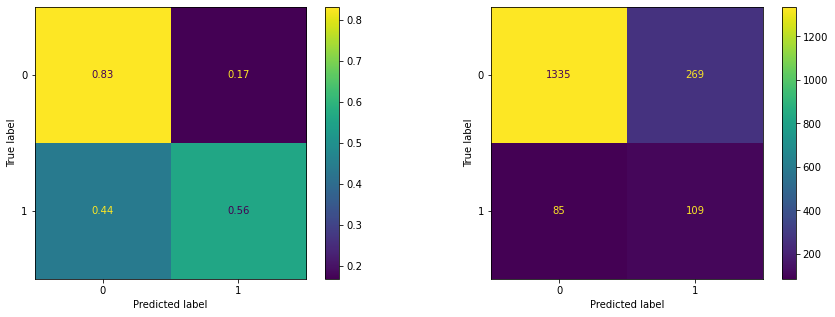

In [22]:
pred_test = get_users(X_train, X_test, y_train, y_test, zero_scale=ZERO_SCALE, n_folds=N_FOLDS, is_test=True)

# SUBMIT

In [24]:
pred = get_users(X, test, y, zero_scale=ZERO_SCALE, n_folds=N_FOLDS, is_test=False)

X shape (5992, 306)
X shape without outers  (5934, 306)


  0%|                                                   | 0/10 [00:00<?, ?it/s]

>Fold 1 of 10: {0: 1033, 1: 698}, scale: 1.48


J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)
j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.3166189	total: 7.58ms	remaining: 7.58s
10:	learn: 0.4699140	total: 92.9ms	remaining: 8.35s
20:	learn: 0.3653295	total: 162ms	remaining: 7.54s
30:	learn: 0.3638968	total: 250ms	remaining: 7.83s
40:	learn: 0.3595989	total: 328ms	remaining: 7.67s
50:	learn: 0.3581662	total: 403ms	remaining: 7.49s
60:	learn: 0.3581662	total: 480ms	remaining: 7.39s
70:	learn: 0.3753582	total: 547ms	remaining: 7.16s
80:	learn: 0.3710602	total: 613ms	remaining: 6.95s
90:	learn: 0.3724928	total: 683ms	remaining: 6.82s
100:	learn: 0.3782235	total: 751ms	remaining: 6.69s
110:	learn: 0.3796562	total: 816ms	remaining: 6.54s
120:	learn: 0.3782235	total: 883ms	remaining: 6.41s
130:	learn: 0.3796562	total: 953ms	remaining: 6.32s
140:	learn: 0.3868195	total: 1.02s	remaining: 6.19s
150:	learn: 0.3911175	total: 1.09s	remaining: 6.11s
160:	learn: 0.4054441	total: 1.17s	remaining: 6.1s
170:	learn: 0.4283668	total: 1.24s	remaining: 6.01s
180:	learn: 0.4269341	total: 1.31s	remaining

 10%|████▎                                      | 1/10 [00:19<02:53, 19.22s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 2 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.2793696	total: 6.63ms	remaining: 6.62s
10:	learn: 0.3624642	total: 83.7ms	remaining: 7.53s
20:	learn: 0.3581662	total: 153ms	remaining: 7.15s
30:	learn: 0.3567335	total: 228ms	remaining: 7.14s
40:	learn: 0.3481375	total: 296ms	remaining: 6.93s
50:	learn: 0.3338109	total: 362ms	remaining: 6.74s
60:	learn: 0.3338109	total: 438ms	remaining: 6.75s
70:	learn: 0.3581662	total: 505ms	remaining: 6.61s
80:	learn: 0.3524355	total: 593ms	remaining: 6.73s
90:	learn: 0.3810888	total: 670ms	remaining: 6.69s
100:	learn: 0.3767908	total: 744ms	remaining: 6.63s
110:	learn: 0.3882521	total: 824ms	remaining: 6.6s
120:	learn: 0.3882521	total: 898ms	remaining: 6.52s
130:	learn: 0.4040115	total: 972ms	remaining: 6.45s
140:	learn: 0.4068768	total: 1.05s	remaining: 6.39s
150:	learn: 0.4083095	total: 1.13s	remaining: 6.35s
160:	learn: 0.4068768	total: 1.2s	remaining: 6.27s
170:	learn: 0.4083095	total: 1.28s	remaining: 6.21s
180:	learn: 0.4111748	total: 1.35s	remaining:

 20%|████████▌                                  | 2/10 [00:39<02:36, 19.58s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 3 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.1762178	total: 8.7ms	remaining: 8.69s
10:	learn: 0.4255014	total: 95.2ms	remaining: 8.56s
20:	learn: 0.4555874	total: 177ms	remaining: 8.26s
30:	learn: 0.4584527	total: 273ms	remaining: 8.54s
40:	learn: 0.4813754	total: 352ms	remaining: 8.23s
50:	learn: 0.4799427	total: 429ms	remaining: 7.98s
60:	learn: 0.4842407	total: 503ms	remaining: 7.75s
70:	learn: 0.4828080	total: 573ms	remaining: 7.49s
80:	learn: 0.4856734	total: 645ms	remaining: 7.32s
90:	learn: 0.4727794	total: 721ms	remaining: 7.2s
100:	learn: 0.4727794	total: 792ms	remaining: 7.04s
110:	learn: 0.4742120	total: 865ms	remaining: 6.93s
120:	learn: 0.4656160	total: 939ms	remaining: 6.82s
130:	learn: 0.4641834	total: 1.02s	remaining: 6.75s
140:	learn: 0.4641834	total: 1.1s	remaining: 6.7s
150:	learn: 0.4684814	total: 1.17s	remaining: 6.6s
160:	learn: 0.4799427	total: 1.25s	remaining: 6.54s
170:	learn: 0.4828080	total: 1.34s	remaining: 6.51s
180:	learn: 0.4828080	total: 1.43s	remaining: 6.

 30%|████████████▉                              | 3/10 [00:59<02:20, 20.11s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 4 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.1318052	total: 5.48ms	remaining: 5.47s
10:	learn: 0.3610315	total: 67.7ms	remaining: 6.08s
20:	learn: 0.4398281	total: 123ms	remaining: 5.75s
30:	learn: 0.4154728	total: 183ms	remaining: 5.73s
40:	learn: 0.4670487	total: 241ms	remaining: 5.63s
50:	learn: 0.4627507	total: 298ms	remaining: 5.54s
60:	learn: 0.4570201	total: 354ms	remaining: 5.45s
70:	learn: 0.4484241	total: 423ms	remaining: 5.53s
80:	learn: 0.4541547	total: 481ms	remaining: 5.46s
90:	learn: 0.4469914	total: 542ms	remaining: 5.42s
100:	learn: 0.4426934	total: 599ms	remaining: 5.33s
110:	learn: 0.4455587	total: 661ms	remaining: 5.29s
120:	learn: 0.4469914	total: 717ms	remaining: 5.21s
130:	learn: 0.4469914	total: 774ms	remaining: 5.14s
140:	learn: 0.4541547	total: 830ms	remaining: 5.05s
150:	learn: 0.4541547	total: 894ms	remaining: 5.03s
160:	learn: 0.4541547	total: 952ms	remaining: 4.96s
170:	learn: 0.4555874	total: 1.01s	remaining: 4.91s
180:	learn: 0.4570201	total: 1.08s	remainin

 40%|█████████████████▏                         | 4/10 [01:17<01:54, 19.10s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 5 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.2593123	total: 5.97ms	remaining: 5.96s
10:	learn: 0.5458453	total: 60.8ms	remaining: 5.46s
20:	learn: 0.4942693	total: 116ms	remaining: 5.39s
30:	learn: 0.5014327	total: 171ms	remaining: 5.36s
40:	learn: 0.4971347	total: 231ms	remaining: 5.39s
50:	learn: 0.4885387	total: 296ms	remaining: 5.5s
60:	learn: 0.4842407	total: 362ms	remaining: 5.57s
70:	learn: 0.4957020	total: 422ms	remaining: 5.51s
80:	learn: 0.4942693	total: 500ms	remaining: 5.67s
90:	learn: 0.4598854	total: 631ms	remaining: 6.3s
100:	learn: 0.4613181	total: 714ms	remaining: 6.35s
110:	learn: 0.4441261	total: 788ms	remaining: 6.31s
120:	learn: 0.4555874	total: 862ms	remaining: 6.26s
130:	learn: 0.4297994	total: 931ms	remaining: 6.17s
140:	learn: 0.4469914	total: 1s	remaining: 6.1s
150:	learn: 0.4484241	total: 1.07s	remaining: 6.03s
160:	learn: 0.4426934	total: 1.15s	remaining: 5.97s
170:	learn: 0.4484241	total: 1.22s	remaining: 5.9s
180:	learn: 0.4971347	total: 1.29s	remaining: 5.86

 50%|█████████████████████▌                     | 5/10 [01:36<01:35, 19.02s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 6 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.0945559	total: 7.84ms	remaining: 7.83s
10:	learn: 0.4097421	total: 70.3ms	remaining: 6.32s
20:	learn: 0.3753582	total: 127ms	remaining: 5.92s
30:	learn: 0.4240688	total: 188ms	remaining: 5.88s
40:	learn: 0.4140401	total: 248ms	remaining: 5.81s
50:	learn: 0.3753582	total: 306ms	remaining: 5.69s
60:	learn: 0.3767908	total: 362ms	remaining: 5.58s
70:	learn: 0.3925501	total: 424ms	remaining: 5.54s
80:	learn: 0.3853868	total: 484ms	remaining: 5.49s
90:	learn: 0.3896848	total: 550ms	remaining: 5.49s
100:	learn: 0.3968481	total: 607ms	remaining: 5.4s
110:	learn: 0.4025788	total: 670ms	remaining: 5.37s
120:	learn: 0.4040115	total: 731ms	remaining: 5.31s
130:	learn: 0.4054441	total: 788ms	remaining: 5.22s
140:	learn: 0.4111748	total: 844ms	remaining: 5.14s
150:	learn: 0.4140401	total: 907ms	remaining: 5.1s
160:	learn: 0.4140401	total: 965ms	remaining: 5.03s
170:	learn: 0.4154728	total: 1.02s	remaining: 4.95s
180:	learn: 0.4212034	total: 1.08s	remaining:

 60%|█████████████████████████▊                 | 6/10 [01:54<01:15, 18.78s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 7 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.1117479	total: 9.23ms	remaining: 9.22s
10:	learn: 0.4498567	total: 84.3ms	remaining: 7.58s
20:	learn: 0.4083095	total: 158ms	remaining: 7.37s
30:	learn: 0.3896848	total: 236ms	remaining: 7.38s
40:	learn: 0.3911175	total: 304ms	remaining: 7.12s
50:	learn: 0.4412607	total: 375ms	remaining: 6.98s
60:	learn: 0.4412607	total: 447ms	remaining: 6.88s
70:	learn: 0.4398281	total: 516ms	remaining: 6.75s
80:	learn: 0.4441261	total: 588ms	remaining: 6.67s
90:	learn: 0.4455587	total: 664ms	remaining: 6.64s
100:	learn: 0.4426934	total: 738ms	remaining: 6.57s
110:	learn: 0.4469914	total: 814ms	remaining: 6.52s
120:	learn: 0.4498567	total: 888ms	remaining: 6.45s
130:	learn: 0.4541547	total: 959ms	remaining: 6.36s
140:	learn: 0.4527221	total: 1.02s	remaining: 6.24s
150:	learn: 0.4641834	total: 1.09s	remaining: 6.15s
160:	learn: 0.4641834	total: 1.17s	remaining: 6.09s
170:	learn: 0.4641834	total: 1.24s	remaining: 6.01s
180:	learn: 0.4670487	total: 1.31s	remainin

 70%|██████████████████████████████             | 7/10 [02:14<00:57, 19.02s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 8 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.7936963	total: 12.8ms	remaining: 12.8s
10:	learn: 0.3911175	total: 112ms	remaining: 10.1s
20:	learn: 0.4398281	total: 208ms	remaining: 9.68s
30:	learn: 0.3739255	total: 306ms	remaining: 9.56s
40:	learn: 0.3409742	total: 401ms	remaining: 9.38s
50:	learn: 0.3653295	total: 502ms	remaining: 9.34s
60:	learn: 0.3653295	total: 596ms	remaining: 9.18s
70:	learn: 0.3753582	total: 695ms	remaining: 9.1s
80:	learn: 0.3896848	total: 781ms	remaining: 8.86s
90:	learn: 0.3868195	total: 883ms	remaining: 8.82s
100:	learn: 0.4040115	total: 973ms	remaining: 8.66s
110:	learn: 0.4083095	total: 1.08s	remaining: 8.62s
120:	learn: 0.3911175	total: 1.17s	remaining: 8.5s
130:	learn: 0.4040115	total: 1.26s	remaining: 8.33s
140:	learn: 0.4527221	total: 1.36s	remaining: 8.28s
150:	learn: 0.4570201	total: 1.45s	remaining: 8.14s
160:	learn: 0.4598854	total: 1.55s	remaining: 8.09s
170:	learn: 0.4627507	total: 1.64s	remaining: 7.94s
180:	learn: 0.4656160	total: 1.74s	remaining: 

 80%|██████████████████████████████████▍        | 8/10 [02:38<00:41, 20.85s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 9 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.0931232	total: 12.4ms	remaining: 12.4s
10:	learn: 0.3653295	total: 95.5ms	remaining: 8.59s
20:	learn: 0.3352436	total: 170ms	remaining: 7.94s
30:	learn: 0.3452722	total: 248ms	remaining: 7.76s
40:	learn: 0.3767908	total: 327ms	remaining: 7.64s
50:	learn: 0.3767908	total: 404ms	remaining: 7.52s
60:	learn: 0.3810888	total: 476ms	remaining: 7.32s
70:	learn: 0.3624642	total: 548ms	remaining: 7.17s
80:	learn: 0.3653295	total: 624ms	remaining: 7.08s
90:	learn: 0.3696275	total: 700ms	remaining: 6.99s
100:	learn: 0.3724928	total: 775ms	remaining: 6.9s
110:	learn: 0.3853868	total: 852ms	remaining: 6.82s
120:	learn: 0.3882521	total: 920ms	remaining: 6.69s
130:	learn: 0.3911175	total: 992ms	remaining: 6.58s
140:	learn: 0.3982808	total: 1.07s	remaining: 6.51s
150:	learn: 0.3997135	total: 1.14s	remaining: 6.4s
160:	learn: 0.4011461	total: 1.21s	remaining: 6.3s
170:	learn: 0.4054441	total: 1.28s	remaining: 6.22s
180:	learn: 0.4040115	total: 1.36s	remaining: 

 90%|██████████████████████████████████████▋    | 9/10 [03:00<00:21, 21.15s/it]J:\Users\user\AppData\Local\Temp/ipykernel_24224/2785562886.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rfc.fit(X_.fillna(0), y_)


>Fold 10 of 10: {0: 1033, 1: 698}, scale: 1.48


j:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.013022
0:	learn: 0.1532951	total: 9.61ms	remaining: 9.6s
10:	learn: 0.4240688	total: 79.8ms	remaining: 7.17s
20:	learn: 0.3710602	total: 151ms	remaining: 7.05s
30:	learn: 0.4169054	total: 229ms	remaining: 7.14s
40:	learn: 0.4183381	total: 302ms	remaining: 7.06s
50:	learn: 0.3896848	total: 371ms	remaining: 6.9s
60:	learn: 0.3724928	total: 446ms	remaining: 6.87s
70:	learn: 0.3796562	total: 514ms	remaining: 6.73s
80:	learn: 0.3911175	total: 586ms	remaining: 6.64s
90:	learn: 0.3724928	total: 660ms	remaining: 6.59s
100:	learn: 0.3782235	total: 731ms	remaining: 6.5s
110:	learn: 0.3796562	total: 803ms	remaining: 6.43s
120:	learn: 0.3810888	total: 874ms	remaining: 6.35s
130:	learn: 0.3796562	total: 941ms	remaining: 6.24s
140:	learn: 0.3825215	total: 1.01s	remaining: 6.16s
150:	learn: 0.4054441	total: 1.09s	remaining: 6.12s
160:	learn: 0.4054441	total: 1.15s	remaining: 6.02s
170:	learn: 0.4183381	total: 1.22s	remaining: 5.93s
180:	learn: 0.4154728	total: 1.29s	remaining: 

100%|██████████████████████████████████████████| 10/10 [03:20<00:00, 20.07s/it]



Feature_importances RF:
count_url                                           13.036
event_type_Информер ВК. Показ                        6.295
url_fnc.rt.ru                                        5.909
count_event                                          5.304
event_type_Обращение в службу заботы о клиентах      4.029
event_type_Включение интернета на 20 минут           3.778
event_type_Гарантированный платеж за деньги          3.683
url_data.sampo.ru                                    3.548
event_type_Оборудование                              3.523
event_type_Отключение услуги Аренда ТВ-приставки     3.461
dtype: float64

Feature_importances XGB:
event_type_Оборудование                              4.220
event_type_Отключение услуги Аренда ТВ-приставки     4.146
event_type_Внутреннее сообщение                      3.944
url_data.sampo.ru                                    3.847
count_url                                            3.844
event_type_Перенос денежных средств              

In [25]:
df_sample_solution['blocked'] = pred.astype(int)

In [26]:
df_sample_solution['blocked'].value_counts()

0    634
1    176
Name: blocked, dtype: int64

In [91]:
df_sample_solution.to_csv('solution.csv', index=False)